In [355]:
import itertools
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as pl
from IPython import display
%matplotlib inline

## GAN Simulations

This notebook is a sandbox for running small-scale simulations and demonstrations for Generative Adversarial Networks (GANs).  

### Base Model

Let's first define some basic neural networks in Tensorflow...

In [356]:
def init_neural_net(layer_sizes, std=.1):
    params = {'w':[], 'b':[]}
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        params['w'].append(tf.Variable(tf.random_normal([n_in, n_out], stddev=std)))
        params['b'].append(tf.Variable(tf.zeros([n_out,])))
    return params

def neural_net(X, params):
    h = [X]
    for w,b in zip(params['w'][:-1], params['b'][:-1]):
        h.append( tf.nn.relu( tf.matmul(h[-1], w) + b ) )
    return tf.matmul(h[-1], params['w'][-1]) + params['b'][-1]

### Gaussian Mixture Simulation
This demo uses data generated from a Gaussian mixture model.  First, let's make a function to simulate the data...

In [357]:
# Draw sample from mixture model
# k ~ Mult(pi)
# z ~ f_k
def draw_samples(pi_arr, mu_arr, cov_arr, n_samples=100):
    comp_arr = np.random.multinomial(n_samples, pi_arr)
    z = []
    for idx, count in enumerate(comp_arr):
        for c in xrange(count):
            z.append(np.random.multivariate_normal(mu_s[idx], cov_s[idx]))
    return np.array(z)

Create the data and symbolic variables...

In [358]:
N = 300 # number of datapoints 
latent_size = 50
vis_size = 2
hidden_size = 500
learning_rate = .05

### Generate True Distribution
# USE JUST ONE GAUSSIAN FOR NOW
pi = np.array([.35, .65])
# define base dists.
mu_s = [np.array([-5., -5.]), np.array([5., 5.])]
cov_s = [np.array([[1., 0.], [0., 1.]]), np.array([[1., 0.], [0., 1.]])]
# draw_samples
X_true = draw_samples(pi, mu_s, cov_s, N)

### Make symbolic variables
Z = tf.placeholder("float", [None, latent_size]) # latent features sampled from prior
X = tf.placeholder("float", [None, vis_size]) # samples to discriminate
Y = tf.placeholder("float", [None, 1]) # labels

Define the discriminator model...

In [359]:
discrim_params = init_neural_net([vis_size, hidden_size, 1]) 
discrim_out = neural_net(X, discrim_params)

discrim_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(discrim_out, Y))
train_discriminator = tf.train.GradientDescentOptimizer(learning_rate).minimize(discrim_cost, var_list=discrim_params['w']+discrim_params['b'])

Define the generator model...

In [360]:
generator_params = init_neural_net([latent_size, hidden_size, vis_size])
generator_out = neural_net(Z, generator_params)
discrim_out_genUpdate = neural_net(generator_out, discrim_params)

generator_cost = tf.reduce_mean(-tf.nn.sigmoid_cross_entropy_with_logits(discrim_out_genUpdate, Y))
train_generator = tf.train.GradientDescentOptimizer(learning_rate).minimize(generator_cost, var_list=generator_params['w']+generator_params['b'])

Let's train...

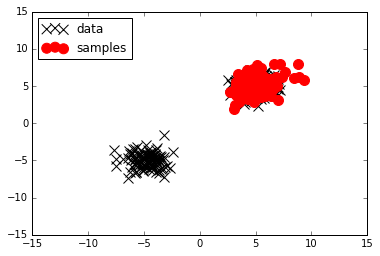

In [361]:
def shuffle_in_unison_inplace(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

def plot_densities(true_data, samples):
    # clear the plot
    display.clear_output(wait=True)

    plt.scatter(true_data[:,0], true_data[:,1], s=100, color='k', marker='x', label="data")
    plt.scatter(samples[:,0], samples[:,1], s=100, color='r', marker='o', label="samples")
    plt.legend(loc=2)
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    plt.show()

# Make labels for training
Y_true = np.ones((N, 1))
Y_gen = np.zeros((N,1))
Y_concat = np.vstack([Y_true, Y_gen])

# Set training params
n_epochs = 150
n_discrim_updates = 10
n_generator_updates = 3

generator_weights = None
generator_biases = None
with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in xrange(n_epochs):
        
        # train discriminator
        discrim_error = 0.
        for idx in xrange(n_discrim_updates):
            # sample from generator
            prior_samples = np.random.normal(size=(N, latent_size))
            genSamples = session.run(generator_out, feed_dict={Z: prior_samples})
        
            # make dataset and shuffle
            train_X = np.vstack([X_true, genSamples])
            train_X, train_Y = shuffle_in_unison_inplace(train_X, Y_concat)
        
            # perform update
            _, l = session.run([train_discriminator, discrim_cost], feed_dict={X: train_X, Y: train_Y})
            discrim_error += l
        # print "Epoch %d.  Discriminator error: %.3f" %(epoch_idx, discrim_error)
        
        # train generator
        for idx in xrange(n_generator_updates):
            # sample from generator again
            prior_samples = np.random.normal(size=(N, latent_size))
        
            # perform update
            session.run(train_generator, feed_dict={Z: prior_samples, Y: Y_gen})
        
        # visualize progress
        if epoch_idx%5 == 0: 
            plot_densities(X_true, session.run(generator_out, feed_dict={Z: np.random.normal(size=(N/2, latent_size))}))
        
    # save the generator params
    generator_weights = [session.run(w) for w in generator_params['w']]
    generator_biases = [session.run(b) for b in generator_params['b']]

The GAN can capture one mode well but not both (at least for the settings I've tried).  This is known problem: "A common problem with GAN framework is that the generator tends to only generate samples that are clustered in one or a few modes of the regions of high data density, instead of spanning the whole range" [[source]](https://arxiv.org/pdf/1609.03126v2.pdf).